In [99]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model12/best_Transformer.pth
/kaggle/input/model12/best_LSTM.pth
/kaggle/input/model12/best_LSTM_Attn.pth
/kaggle/input/dlrandom-1/best_Transformer.pth
/kaggle/input/dlrandom-1/jena_climate.zip
/kaggle/input/dlrandom-1/jena_climate_2009_2016.csv
/kaggle/input/dlrandom-1/__results__.html
/kaggle/input/dlrandom-1/best_LSTM.pth
/kaggle/input/dlrandom-1/__notebook__.ipynb
/kaggle/input/dlrandom-1/best_LSTM_Attn.pth
/kaggle/input/dlrandom-1/__output__.json
/kaggle/input/dlrandom-1/custom.css
/kaggle/input/dlrandom-1/__results___files/__results___9_1.png
/kaggle/input/dlrandom-1/__results___files/__results___8_3.png
/kaggle/input/dlrandom-1/__results___files/__results___8_5.png


In [100]:
import os
import zipfile
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
# 
# 1. CẤU HÌNH
class Config:
    csv_path = "jena_climate_2009_2016.csv"
    url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
    target_col_name = 'T (degC)'
    
    # Model Params
    input_window = 96   
    forecast_horizon = 12  
    d_model = 32

    num_layers = 2          # Số tầng
    dropout = 0.3           
    
    # Training
    batch_size = 64
    epochs = 120           
    learning_rate = 1e-4
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_workers = 2
    OUTPUT_DIR = '/kaggle/input/model12'
cfg = Config()



In [101]:
# 2. DATA PIPELINE
class WeatherDataset(Dataset):
    def __init__(self, data, input_window, forecast_horizon, target_col_idx):
        self.data = torch.FloatTensor(data)
        self.input_window = input_window
        self.forecast_horizon = forecast_horizon
        self.target_col_idx = target_col_idx

    def __len__(self):
        return len(self.data) - self.input_window - self.forecast_horizon + 1

    def __getitem__(self, idx):
        # Input: [Window, Features]
        past = self.data[idx : idx + self.input_window]
        # Target: [Horizon] -> [Horizon, 1]
        future = self.data[idx + self.input_window : idx + self.input_window + self.forecast_horizon, self.target_col_idx]
        return past, future.unsqueeze(-1)

def prepare_weather_data(config):
    if not os.path.exists(config.csv_path):
        print(f"Downloading data from {config.url}...")
        os.system(f"wget {config.url} -O jena_climate.zip")
        with zipfile.ZipFile("jena_climate.zip", 'r') as z: z.extractall(".")
    
    # Subsampling
    df = pd.read_csv(config.csv_path)
    df = df[5::6].reset_index(drop=True) # Lấy mẫu mỗi giờ 
    # Feature Engineering
    # Chuyển đổi gió
    wv = df.pop('wv (m/s)')
    wd_rad = df.pop('wd (deg)') * np.pi / 180
    df['Wx'], df['Wy'] = wv * np.cos(wd_rad), wv * np.sin(wd_rad)
    
    # Chuyển đổi thời gian
    date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
    timestamp = date_time.map(pd.Timestamp.timestamp)
    day = 24*60*60
    year = (365.2425)*24*3600
    df['Day sin'], df['Day cos'] = np.sin(timestamp * (2*np.pi/day)), np.cos(timestamp * (2*np.pi/day))
    df['Year sin'], df['Year cos'] = np.sin(timestamp * (2*np.pi/year)), np.cos(timestamp * (2*np.pi/year))

    # Chọn cột và chuẩn hóa
    cols = ['p (mbar)', 'T (degC)', 'rho (g/m**3)', 'Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
    print(cols)
    df_final = df[cols].copy()

    target_idx = df_final.columns.get_loc(config.target_col_name)
    config.n_features = df_final.shape[1]

    # Chia Train/Val/Test (80% - 10% - 10%)
    n = len(df_final)
    scaler = StandardScaler()
    train_data = scaler.fit_transform(df_final.iloc[:int(n*0.8)].values)
    val_data = scaler.transform(df_final.iloc[int(n*0.8):int(n*0.9)].values)
    test_data = scaler.transform(df_final.iloc[int(n*0.9):].values)

    # Tạo DataLoader
    def get_loader(d, shuffle=False):
        ds = WeatherDataset(d, config.input_window, config.forecast_horizon, target_idx)
        return DataLoader(ds, batch_size=config.batch_size, shuffle=shuffle, num_workers=config.num_workers)

    return get_loader(train_data), get_loader(val_data), get_loader(test_data), scaler, target_idx

In [102]:
# 3. MODEL DEFINITIONS

class LSTMSeq2Seq(nn.Module):
    def __init__(self, cfg, target_idx):
        super().__init__()
        self.target_idx = target_idx
        self.forecast_horizon = cfg.forecast_horizon
        
        # Encoder: Multi-layer LSTM
        self.encoder = nn.LSTM(
            input_size=cfg.n_features, 
            hidden_size=cfg.d_model, 
            num_layers=cfg.num_layers, 
            dropout=cfg.dropout,
            batch_first=True
        )
        
        # Decoder: Multi-layer LSTM
        self.decoder = nn.LSTM(
            input_size=1, 
            hidden_size=cfg.d_model, 
            num_layers=cfg.num_layers,
            dropout=cfg.dropout,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(cfg.d_model, 1)

    def forward(self, past_features, future_target=None, teacher_forcing_ratio=0.5):
        # 1. Encode
        _, (h, c) = self.encoder(past_features)
        
        # 2. Decode Loop
        curr_input = past_features[:, -1, self.target_idx].unsqueeze(1).unsqueeze(2) # (B, 1, 1)
        outputs = []
        
        for t in range(self.forecast_horizon):
            dec_out, (h, c) = self.decoder(curr_input, (h, c))
            step_out = self.output_layer(dec_out.squeeze(1)) # (B, 1)
            outputs.append(step_out.unsqueeze(1))
            
            # Scheduled Sampling Logic
            if future_target is not None:
                if random.random() < teacher_forcing_ratio:
                    curr_input = future_target[:, t, :].unsqueeze(1) # Teacher Forcing
                else:
                    curr_input = step_out.unsqueeze(1) # Autoregressive
            else:
                curr_input = step_out.unsqueeze(1)
                
        return torch.cat(outputs, dim=1)



In [103]:
class LSTMAttention(nn.Module):
    def __init__(self, cfg, target_idx):
        super().__init__()
        self.target_idx = target_idx
        self.forecast_horizon = cfg.forecast_horizon
        self.d_model = cfg.d_model
        
        self.encoder = nn.LSTM(
            cfg.n_features, cfg.d_model, 
            num_layers=cfg.num_layers, 
            dropout=cfg.dropout,
            batch_first=True
        )
        
        self.attn = nn.Linear(cfg.d_model * 2, cfg.d_model)
        self.v = nn.Linear(cfg.d_model, 1, bias=False)
        
        self.decoder = nn.LSTM(
            input_size=1 + cfg.d_model, # Input = Target + Context
            hidden_size=cfg.d_model, 
            num_layers=cfg.num_layers,
            dropout=cfg.dropout,
            batch_first=True
        )
        
        self.output_layer = nn.Linear(cfg.d_model, 1)

    def forward(self, past_features, future_target=None, teacher_forcing_ratio=0.5):
        enc_out, (h, c) = self.encoder(past_features)
        
        curr_input = past_features[:, -1, self.target_idx].unsqueeze(1).unsqueeze(2)
        outputs = []
        
        for t in range(self.forecast_horizon):
            # Attention Mechanism (Bahdanau Style)
            h_last = h[-1].unsqueeze(1).repeat(1, enc_out.size(1), 1) # Use last layer hidden
            energy = torch.tanh(self.attn(torch.cat((h_last, enc_out), dim=2)))
            weights = torch.softmax(self.v(energy), dim=1)
            context = torch.sum(weights * enc_out, dim=1).unsqueeze(1)
            
            # Decoder Input = Previous Output + Context
            rnn_input = torch.cat((curr_input, context), dim=2)
            
            dec_out, (h, c) = self.decoder(rnn_input, (h, c))
            step_out = self.output_layer(dec_out.squeeze(1))
            outputs.append(step_out.unsqueeze(1))
            
            if future_target is not None:
                if random.random() < teacher_forcing_ratio:
                    curr_input = future_target[:, t, :].unsqueeze(1)
                else:
                    curr_input = step_out.unsqueeze(1)
            else:
                curr_input = step_out.unsqueeze(1)

        return torch.cat(outputs, dim=1)



In [104]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1), :]

class TransformerModel(nn.Module):
    def __init__(self, cfg, target_idx):
        super().__init__()
        self.target_idx = target_idx
        self.forecast_horizon = cfg.forecast_horizon
        self.src_embed = nn.Linear(cfg.n_features, cfg.d_model)
        self.tgt_embed = nn.Linear(1, cfg.d_model)
        self.pos_enc = PositionalEncoding(cfg.d_model)
        
        self.transformer = nn.Transformer(
            d_model=cfg.d_model, 
            nhead=4, 
            num_encoder_layers=cfg.num_layers, 
            num_decoder_layers=cfg.num_layers, 
            dim_feedforward=cfg.d_model*4, 
            dropout=cfg.dropout,
            batch_first=True
        )
        self.output_layer = nn.Linear(cfg.d_model, 1)

    def generate_mask(self, sz, device):
        mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, past_features, future_target=None, teacher_forcing_ratio=1.0):
        src_emb = self.pos_enc(self.src_embed(past_features))
        device = past_features.device
        
        if future_target is not None:
            start_token = past_features[:, -1, self.target_idx].unsqueeze(1).unsqueeze(1)
            tgt_input = torch.cat([start_token, future_target[:, :-1, :]], dim=1)
            tgt_emb = self.pos_enc(self.tgt_embed(tgt_input))
            tgt_mask = self.generate_mask(tgt_emb.size(1), device)
            out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask)
            return self.output_layer(out)
        else:
            # Eval: Autoregressive
            memory = self.transformer.encoder(src_emb)
            curr_val = past_features[:, -1, self.target_idx].unsqueeze(1).unsqueeze(1)
            tgt_inp = curr_val
            outputs = []
            for _ in range(self.forecast_horizon):
                tgt_emb = self.pos_enc(self.tgt_embed(tgt_inp))
                tgt_mask = self.generate_mask(tgt_emb.size(1), device)
                out = self.transformer.decoder(tgt_emb, memory, tgt_mask=tgt_mask)
                next_val = self.output_layer(out[:, -1, :]).unsqueeze(1)
                outputs.append(next_val)
                tgt_inp = torch.cat([tgt_inp, next_val], dim=1)
            return torch.cat(outputs, dim=1)



In [105]:
#  TRAINING ENGINE
class EarlyStopping:
    def __init__(self, patience=10, delta=0, path='checkpoint.pth', verbose=False):
        self.patience = patience
        self.delta = delta
        self.path = path
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_loss = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Lưu model vào thư mục Kaggle Working.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.best_loss = val_loss

# def train_and_evaluate(model_name, model_class, loaders, cfg, target_idx):
#     print(f"\n Training Model: {model_name}...")
#     model = model_class(cfg, target_idx).to(cfg.device)
#     optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
#     criterion = nn.MSELoss()
#     mae_metric = mean_absolute_error
    
#     train_loader, val_loader, _ = loaders
    
#     save_name = f"best_{model_name}.pth"
#     checkpoint_path = os.path.join(cfg.OUTPUT_DIR, save_name)
    
#     # Khởi tạo EarlyStopping 
#     early_stopping = EarlyStopping(patience=10, delta=0.0001, path=checkpoint_path, verbose=False)
    
#     history = {'train_loss': [], 'val_loss': [], 'val_mae': []}

#     for epoch in range(cfg.epochs):
#         # Scheduled Sampling Decay
#         ratio = max(0.0, 1.0 - (epoch / 20))
        
#         # --- TRAIN ---
#         model.train()
#         train_loss = 0
#         for x, y in train_loader:
#             x, y = x.to(cfg.device), y.to(cfg.device)
#             optimizer.zero_grad()
#             preds = model(x, future_target=y, teacher_forcing_ratio=ratio)
#             loss = criterion(preds, y)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
        
#         avg_train_loss = train_loss / len(train_loader)
        
#         # --- VALIDATE ---
#         model.eval()
#         val_loss = 0
#         val_mae = 0
#         with torch.no_grad():
#             for x, y in val_loader:
#                 x, y = x.to(cfg.device), y.to(cfg.device)
#                 preds = model(x, future_target=None)
#                 val_loss += criterion(preds, y).item()
#                 val_mae += mae_metric(y.cpu().numpy().flatten(), preds.cpu().numpy().flatten())
        
#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_mae = val_mae / len(val_loader)
        
#         history['train_loss'].append(avg_train_loss)
#         history['val_loss'].append(avg_val_loss)
#         history['val_mae'].append(avg_val_mae)
        
#         print(f"Epoch {epoch+1:02d} | Ratio: {ratio:.2f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val MAE: {avg_val_mae:.4f}")
        
#         # Gọi EarlyStopping tự lưu vào /kaggle/working/ 
#         early_stopping(avg_val_mae, model)
        
#         if early_stopping.early_stop:
#             print(f">>>  Early Stopping triggered at epoch {epoch+1}")
#             break
#     # Load lại đúng file đã lưu trong thư mục working
#     if os.path.exists(checkpoint_path):
#         print(f"Loading best model weights from {checkpoint_path}...")
#         model.load_state_dict(torch.load(checkpoint_path))
#     else:
#         print(" Warning: No checkpoint found. Returning last model.")
    
#     return model, history


In [106]:
def train_and_evaluate(model_name, model_class, loaders, cfg, target_idx):
    print(f"\nSetup inference mode for: {model_name}...")

    model = model_class(cfg, target_idx).to(cfg.device)

    checkpoint_path = os.path.join(
        cfg.OUTPUT_DIR, f"best_{model_name}.pth"
    )
    print(f"Loading weights from {checkpoint_path}...")
    model.load_state_dict(
        torch.load(checkpoint_path, map_location=cfg.device)
    )
    model.eval()
    return model, {}


In [107]:
def print_model_summary(model, name):
    print(f"{name.upper()} MODEL SUMMARY")

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\n[Overall]")
    print(f"Total parameters     : {total_params:,}")
    print(f"Trainable parameters : {trainable_params:,}")

    print("\n[Architecture Details]")
    for module_name, module in model.named_children():
        module_params = sum(p.numel() for p in module.parameters())

        # Mô tả ngắn gọn theo loại module
        if isinstance(module, torch.nn.LSTM):
            desc = (
                f"LSTM("
                f"input_size={module.input_size}, "
                f"hidden_size={module.hidden_size}, "
                f"num_layers={module.num_layers}, "
                f"dropout={module.dropout}"
                f")"
            )

        elif isinstance(module, torch.nn.Linear):
            desc = (
                f"Linear("
                f"in_features={module.in_features}, "
                f"out_features={module.out_features}"
                f")"
            )

        elif isinstance(module, torch.nn.Transformer):
            desc = (
                f"Transformer("
                f"d_model={module.d_model}, "
                f"nhead={module.nhead}, "
                f"enc_layers={module.encoder.num_layers}, "
                f"dec_layers={module.decoder.num_layers}"
                f")"
            )

        else:
            desc = module.__class__.__name__

        print(f"- {module_name:15s}: {desc}")
        print(f"  ↳ params: {module_params:,}")


Checking device: cuda
['p (mbar)', 'T (degC)', 'rho (g/m**3)', 'Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']

Setup inference mode for: LSTM...
Loading weights from /kaggle/input/model12/best_LSTM.pth...

Setup inference mode for: LSTM_Attn...
Loading weights from /kaggle/input/model12/best_LSTM_Attn.pth...

Setup inference mode for: Transformer...
Loading weights from /kaggle/input/model12/best_Transformer.pth...

MODEL SUMMARIES (Layers=2, Dropout=0.3)
LSTM MODEL SUMMARY

[Overall]
Total parameters     : 26,913
Trainable parameters : 26,913

[Architecture Details]
- encoder        : LSTM(input_size=9, hidden_size=32, num_layers=2, dropout=0.3)
  ↳ params: 13,952
- decoder        : LSTM(input_size=1, hidden_size=32, num_layers=2, dropout=0.3)
  ↳ params: 12,928
- output_layer   : Linear(in_features=32, out_features=1)
  ↳ params: 33
LSTM_ATTN MODEL SUMMARY

[Overall]
Total parameters     : 33,121
Trainable parameters : 33,121

[Architecture Details]
- encoder        : LSTM

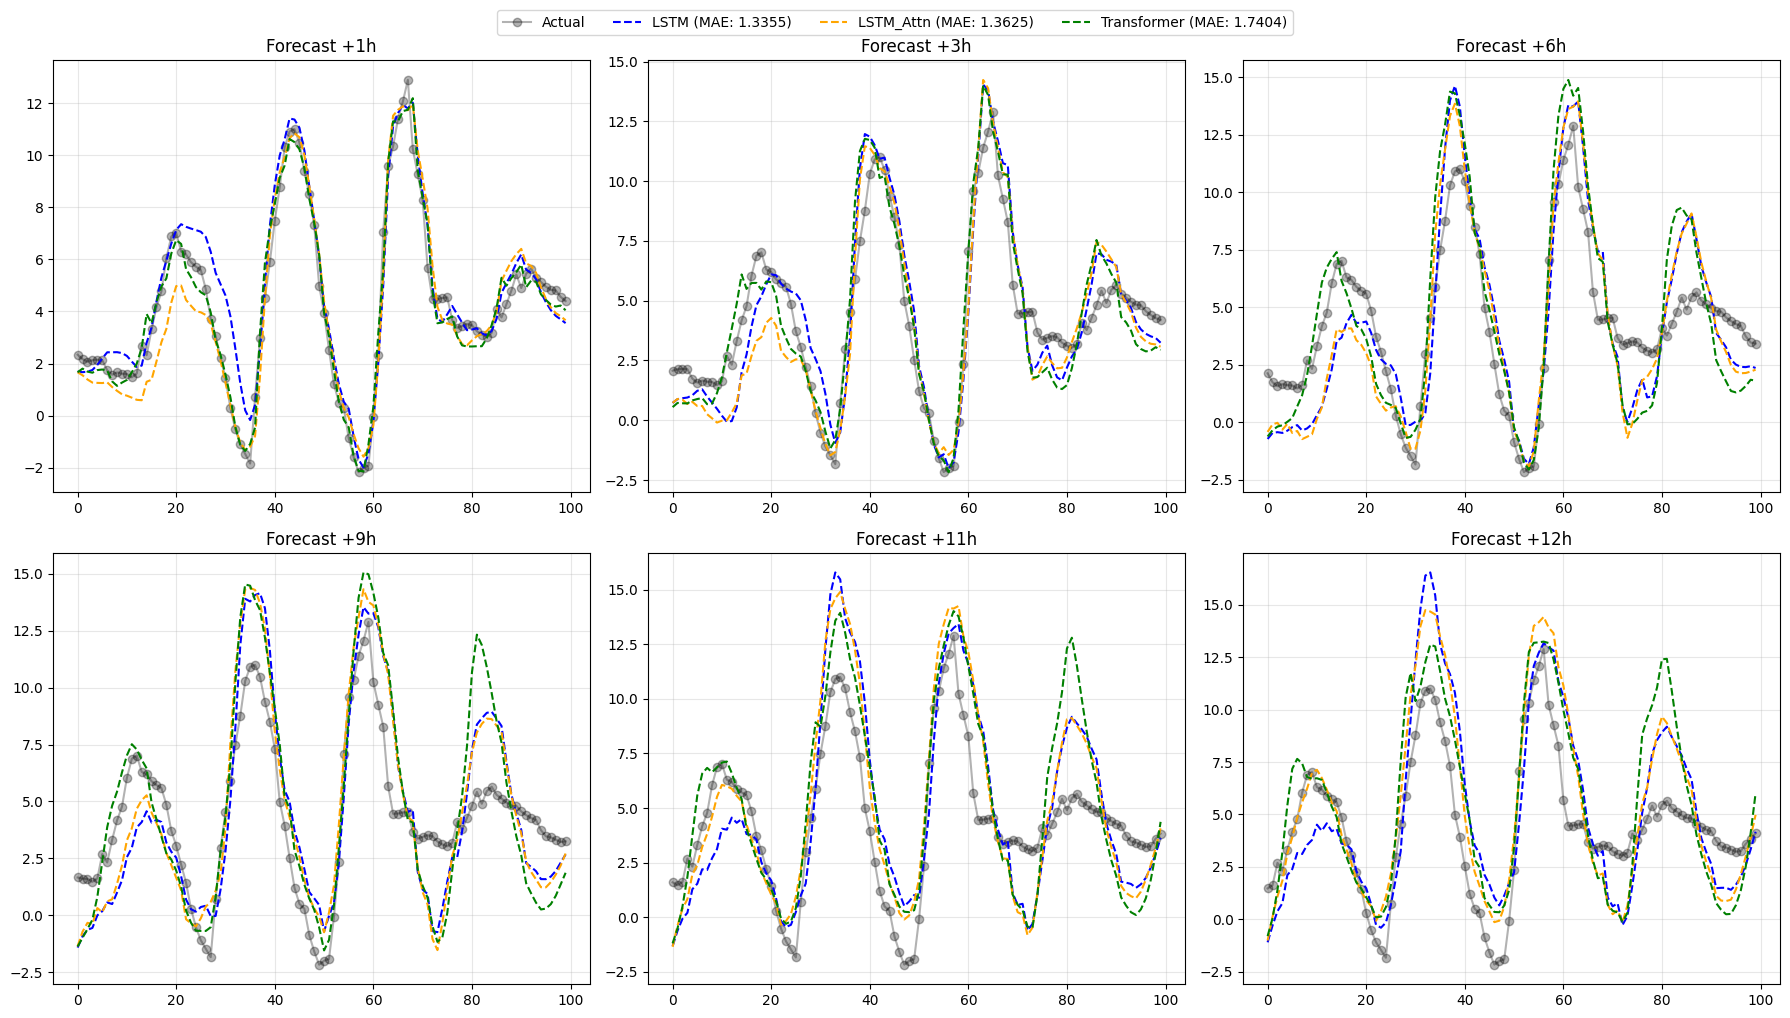

BẢNG TỔNG HỢP CHỈ SỐ LỖI
         Model    MAE   RMSE    MSE
0         LSTM 1.3355 1.7812 3.1725
1    LSTM_Attn 1.3625 1.8058 3.2610
2  Transformer 1.7404 2.2626 5.1194


In [108]:
# A. Load Data
print(f"Checking device: {cfg.device}")
train_loader, val_loader, test_loader, scaler, target_idx = prepare_weather_data(cfg)
loaders = (train_loader, val_loader, test_loader)

# B. Run Training
model_classes = {
    'LSTM': LSTMSeq2Seq,
    'LSTM_Attn': LSTMAttention,
    'Transformer': TransformerModel
}

trained_models = {}
histories = {}

for name, cls in model_classes.items():
    trained_models[name], hist = train_and_evaluate(name, cls, loaders, cfg, target_idx)
    histories[name] = hist


# C. Print Model Summaries
print(f"\nMODEL SUMMARIES (Layers={cfg.num_layers}, Dropout={cfg.dropout})")

for name, model in trained_models.items():
    print_model_summary(model, name)


# # D. Plot Training History
# plt.figure(figsize=(15, 6))

# # Plot Train Loss vs Val Loss
# plt.subplot(1, 2, 1)
# for name, hist in histories.items():
#     line, = plt.plot(hist['train_loss'], label=f'{name} Train')
#     plt.plot(hist['val_loss'], linestyle='--', color=line.get_color(), label=f'{name} Val')
# plt.title('Loss Curve: Train (Solid) vs Val (Dashed)')
# plt.xlabel('Epochs'); plt.ylabel('MSE Loss'); plt.grid(True, alpha=0.3); plt.legend()

# # Plot Validation MAE
# plt.subplot(1, 2, 2)
# for name, hist in histories.items():
#     plt.plot(hist['val_mae'], marker='.', label=f'{name}')
# plt.title('Validation MAE (Lower is Better)'); plt.xlabel('Epochs'); plt.ylabel('MAE'); plt.grid(True, alpha=0.3); plt.legend()

# plt.tight_layout(); plt.show()




def get_predictions(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(cfg.device)
            p = model(x, future_target=None).cpu().numpy()
            preds.append(p); trues.append(y.numpy())
    return np.concatenate(trues, axis=0), np.concatenate(preds, axis=0)

def inv(d):
    flat = d.flatten()
    dummy = np.zeros((len(flat), cfg.n_features))
    dummy[:, target_idx] = flat
    return scaler.inverse_transform(dummy)[:, target_idx].reshape(d.shape[:2])

# Tính toán Dữ liệu & Chỉ số 

y_test_scaled, _ = get_predictions(trained_models['LSTM'], test_loader)
y_test_inv = inv(y_test_scaled) # Ground Truth

model_preds_inv = {}
model_metrics = {}

for name, model in trained_models.items():
    _, p_scaled = get_predictions(model, test_loader)
    preds_inv = inv(p_scaled)
    model_preds_inv[name] = preds_inv
    
    # Tính chỉ số trên toàn bộ tập Test
    mae_val = mean_absolute_error(y_test_inv.flatten(), preds_inv.flatten())
    mse_val = mean_squared_error(y_test_inv.flatten(), preds_inv.flatten())
    rmse_val = np.sqrt(mse_val)
    
    model_metrics[name] = {
        "MAE": mae_val,
        "RMSE": rmse_val,
        "MSE": mse_val,
        "Preds": preds_inv
    }

# 3. Vẽ Biểu đồ
print("Plotting charts...")
steps_to_plot = [0, 2, 5, 8, 10, 11]
zoom_slice = slice(0, 100)
colors = {'LSTM': 'blue', 'LSTM_Attn': 'orange', 'Transformer': 'green'}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, step in enumerate(steps_to_plot):
    ax = axes[i]
    
    # Vẽ đường thực tế
    ax.plot(y_test_inv[zoom_slice, step], 'k-o', alpha=0.3, label='Actual' if i==0 else "")
    
    # Vẽ đường dự báo
    for name, metrics in model_metrics.items():
        preds = metrics["Preds"]
        mae_val = metrics["MAE"] # Lấy chỉ số tổng đã tính ở trên
        
        label = f"{name} (MAE: {mae_val:.4f})" if i==0 else f"MAE:{mae_val:.2f}"
        
        ax.plot(preds[zoom_slice, step], '--', color=colors.get(name,'red'), label=label, lw=1.5)
        
    ax.set_title(f"Forecast +{step+1}h")
    ax.grid(True, alpha=0.3)
    if i==0: fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4)

plt.tight_layout()
plt.show()

#  Hiển thị Bảng Thống kê
print("BẢNG TỔNG HỢP CHỈ SỐ LỖI")


table_data = []
for name, metrics in model_metrics.items():
    table_data.append({
        "Model": name,
        "MAE": metrics["MAE"],
        "RMSE": metrics["RMSE"],
        "MSE": metrics["MSE"]
    })

df_metrics = pd.DataFrame(table_data)
pd.options.display.float_format = '{:,.4f}'.format
print(df_metrics)


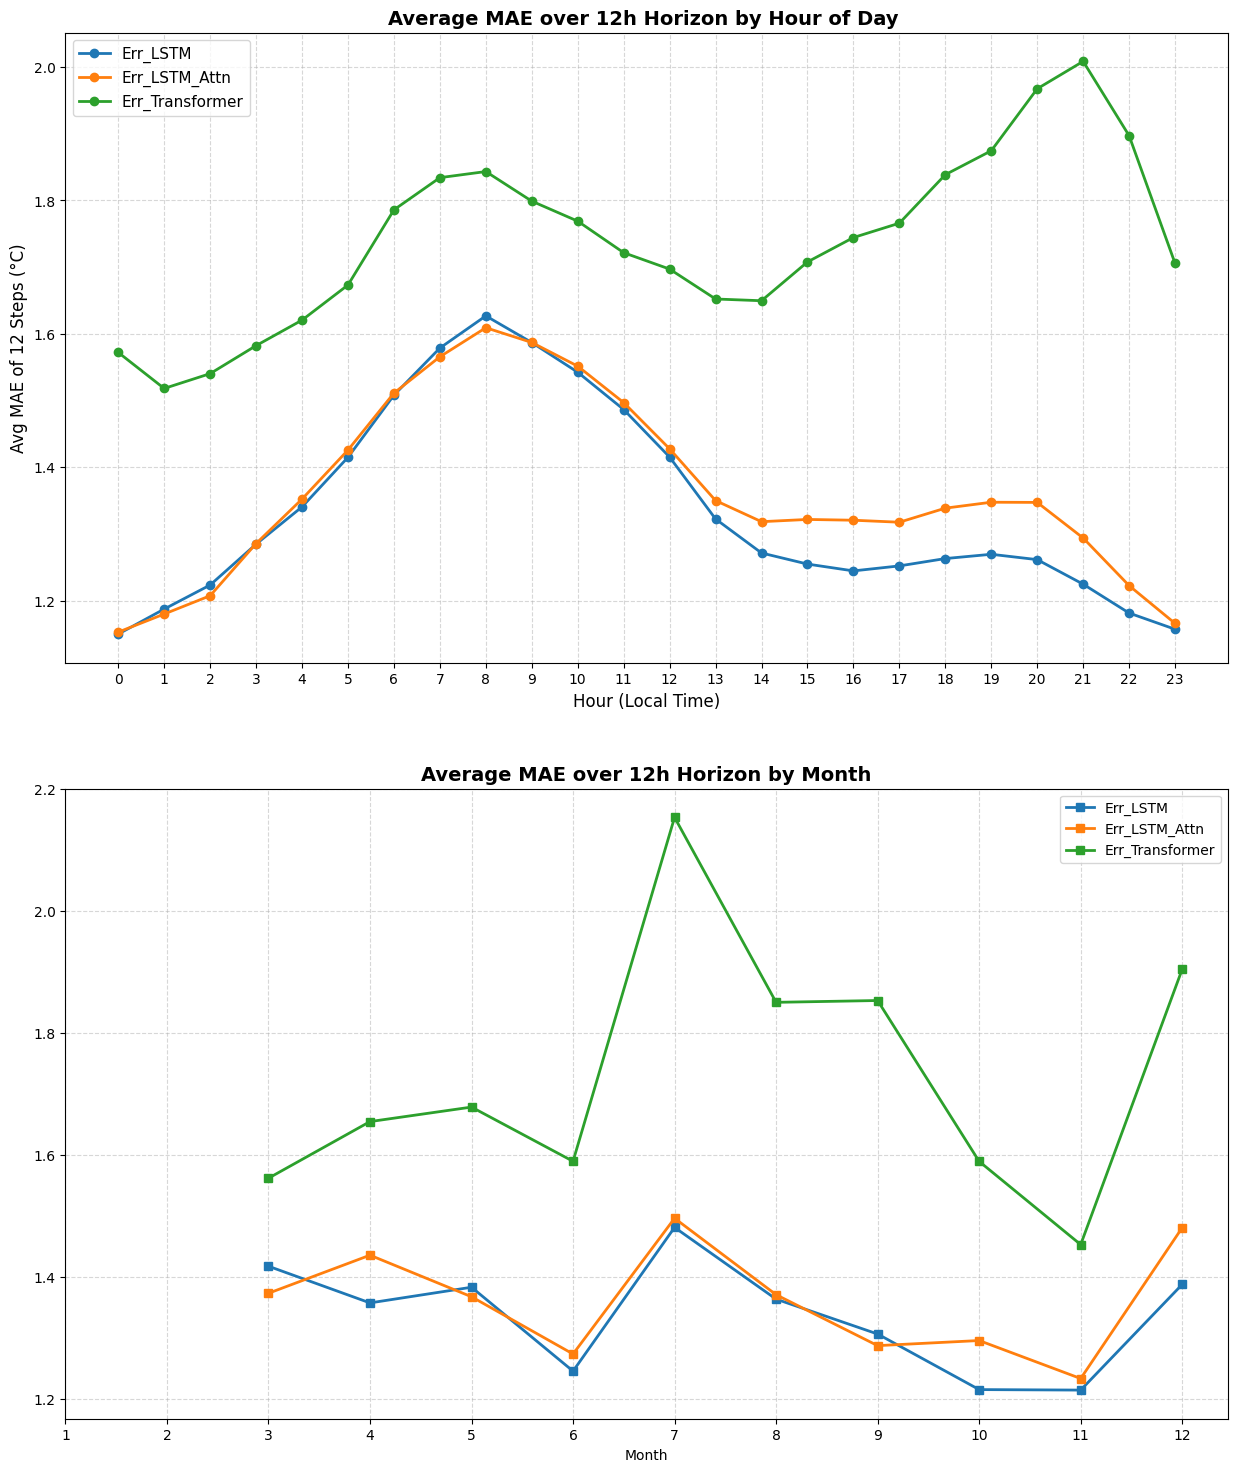

In [109]:
import seaborn as sns
import matplotlib.dates as mdates
def get_test_timestamps_localized(cfg, num_test_samples):

    df = pd.read_csv(cfg.csv_path)
    df = df[5::6].reset_index(drop=True) 
    
    dates = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

    dates_localized = dates.dt.tz_localize('UTC').dt.tz_convert('Europe/Berlin')
    
    n = len(df)
    test_start_idx = int(n * 0.9) # Tập Test là 10% cuối cùng
    
    # Logic căn chỉnh thời gian:
    # - Mẫu Test đầu tiên dùng cửa sổ input: [test_start_idx : test_start_idx + window]
    # - Bước dự báo đầu tiên (+1h) sẽ nằm ngay sau cửa sổ input đó.
    start_target_idx = test_start_idx + cfg.input_window
    
    # Lấy từ start_target_idx đến đủ số lượng mẫu (num_test_samples)
    target_dates = dates_localized.iloc[start_target_idx : start_target_idx + num_test_samples]
    return target_dates.reset_index(drop=True)
num_samples = y_test_inv.shape[0]
test_timestamps = get_test_timestamps(cfg, num_samples)

df_analysis = pd.DataFrame({
    'Timestamp': test_timestamps,
})

# Trích xuất đặc trưng thời gian
df_analysis['Hour'] = df_analysis['Timestamp'].dt.hour
df_analysis['Month'] = df_analysis['Timestamp'].dt.month
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
df_analysis['Season'] = ((df_analysis['Month'] % 12 + 3) // 3).map(season_map)

for name, preds in model_preds_inv.items():
    all_steps_error = np.abs(y_test_inv - preds) 
    avg_error_over_horizon = np.mean(all_steps_error, axis=1)
    
    df_analysis[f'Err_{name}'] = avg_error_over_horizon


fig, axes = plt.subplots(2, 1, figsize=(15, 18))
metric_cols = [f'Err_{name}' for name in model_preds_inv.keys()]

# Chart 1: Giờ trong ngày
df_hour = df_analysis.groupby('Hour')[metric_cols].mean()
df_hour.plot(ax=axes[0], marker='o', linewidth=2)
axes[0].set_title('Average MAE over 12h Horizon by Hour of Day ', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour (Local Time)', fontsize=12)
axes[0].set_ylabel('Avg MAE of 12 Steps (°C)', fontsize=12)
axes[0].set_xticks(range(0, 24))
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend(fontsize=11)
# Chart 2: Tháng
df_month = df_analysis.groupby('Month')[metric_cols].mean()
df_month.plot(ax=axes[1], marker='s', linewidth=2)
axes[1].set_title('Average MAE over 12h Horizon by Month', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(1, 13))
axes[1].grid(True, linestyle='--', alpha=0.5)
